##### Импорт библиотек

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.special import expit

In [96]:
df = pd.read_csv("data/ready data.csv")

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   comment                         1800 non-null   object 
 1   rating                          1800 non-null   float64
 2   Вопрос не решен                 1800 non-null   int64  
 3   Вопрос решен                    1800 non-null   int64  
 4   Не понравился результат услуги  1800 non-null   int64  
 5   Понравилась работа сотрудников  1800 non-null   int64  
 6   Понравилась скорость работы     1800 non-null   int64  
 7   Понравилось качество услуги     1800 non-null   int64  
 8   Понравился результат услуги     1800 non-null   int64  
 9   Претензии и предложения         1800 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 140.8+ KB


(                                        comment  rating  Вопрос не решен  \
 0                                       спасибо     5.0                0   
 1                                      спасибо!     5.0                0   
 2                                      Отлично      5.0                0   
 3  Благодарю за оперативное решение проблемы !      5.0                0   
 4         Прекрасный специалист! Побольше таких     5.0                0   
 
    Вопрос решен  Не понравился результат услуги  \
 0             1                               0   
 1             1                               0   
 2             0                               0   
 3             1                               0   
 4             0                               0   
 
    Понравилась работа сотрудников  Понравилась скорость работы  \
 0                               0                            0   
 1                               0                            0   
 2                   

##### Tfidf-векторизация текста, разделение на обучающую и тестовую выборку с сохранением дисбаланса лейблов

In [97]:
X_raw = df["comment"]
y = df.iloc[:, 2:]

mask = X_raw.notnull() & (X_raw.str.strip() != "")
X_raw = X_raw[mask]
y = y[mask]

# Приводим метки к числам
y = y.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_raw)
X = X.toarray()
y_array = y.values.astype(int)

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y_array, test_size=0.3
)

X_train_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_train).all(axis=1)))].reset_index(drop=True)
X_test_raw = X_raw.iloc[np.ravel(np.where(np.isin(X, X_test).all(axis=1)))].reset_index(drop=True)

# Сохраняем векторизатор
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

##### Модель LinearSVC

In [98]:
param_grid_svc = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__class_weight': ['balanced'],
    'estimator__max_iter': [10000]
}

# Базовая модель
base_svc = OneVsRestClassifier(LinearSVC())

# GridSearch
grid_search_svc = GridSearchCV(
    estimator=base_svc,
    param_grid=param_grid_svc,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучение с подбором параметров
grid_search_svc.fit(X_train, y_train)

# Лучшая модель
svc_model = grid_search_svc.best_estimator_

# Предсказания
y_pred_svc = svc_model.predict(X_test)

print("\nLinear SVC")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_svc = []
f1_values_svc = []
labels_svc = []

# Получаем decision_function (shape [n_samples, n_classes])
y_scores = svc_model.decision_function(X_test)

# Применяем сигмоиду для перевода в вероятности
y_proba_svc = expit(y_scores)

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_proba_svc[:, i])
        f1 = f1_score(y_test[:, i], y_pred_svc[:, i])              # f1 — по меткам
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_svc.append(auc_val)
        f1_values_svc.append(f1)
        labels_svc.append(col)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_svc:
    avg_roc_auc_svc = np.mean(roc_auc_values_svc)
    avg_f1_svc = np.mean(f1_values_svc)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_svc:>10.3f} {avg_f1_svc:>10.3f}")


# Получаем decision_function (shape [n_samples, n_classes])
y_scores = svc_model.decision_function(X_test)

# Применяем сигмоиду для перевода в вероятности
y_proba_svc = expit(y_scores)

# Сохранение модели
joblib.dump(svc_model, "linear_svc_model.pkl")

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Linear SVC
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос не решен                               0.957      0.506
Вопрос решен                                  0.828      0.735
Не понравился результат услуги                0.930      0.468
Понравилась работа сотрудников                0.901      0.689
Понравилась скорость работы                   0.974      0.897
Понравилось качество услуги                   0.884      0.664
Понравился результат услуги                   0.807      0.581
Претензии и предложения                       0.953      0.652
-----------------------------------------------------------------
Average ROC-AUC / F1                          0.904      0.649


['linear_svc_model.pkl']

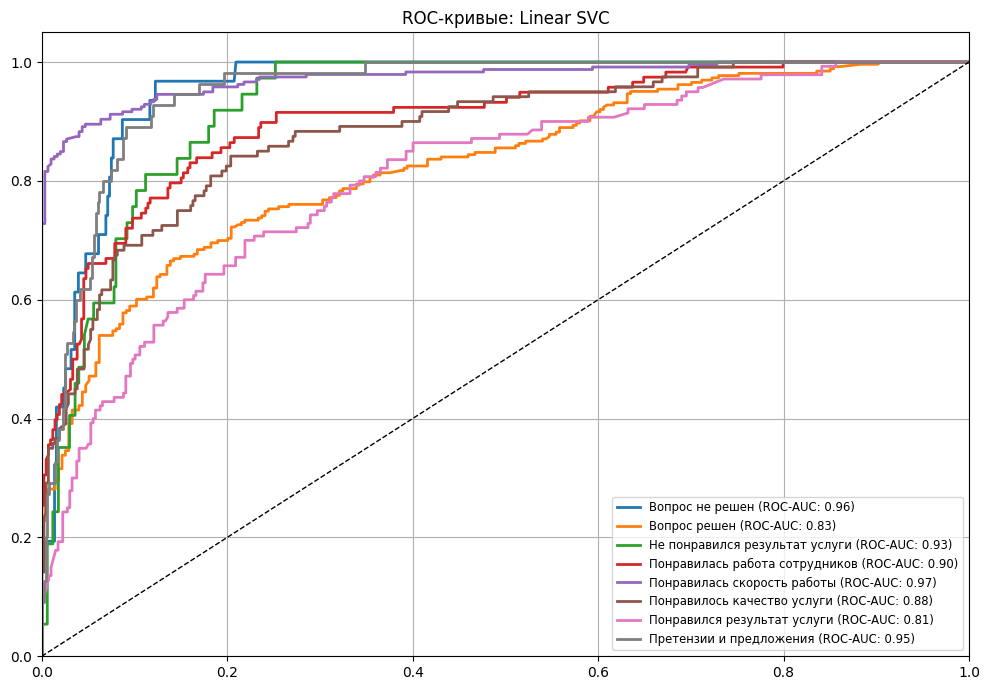

In [99]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba_svc[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Linear SVC')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Классификация на основе модели LinearSVC

In [100]:
import joblib
from scipy.special import expit

# Загружаем модель и векторизатор
svc_model = joblib.load("linear_svc_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Список меток
labels = [
    'Вопрос не решен',
    'Вопрос решен',
    'Не понравился результат услуги',
    'Понравилась работа сотрудников',
    'Понравилась скорость работы',
    'Понравилось качество услуги',
    'Понравился результат услуги',
    'Претензии и предложения'
]

def predict_labels_svc(text, threshold=0.5):
    X = vectorizer.transform([text])
    scores = svc_model.decision_function(X)
    probs = expit(scores)
    preds = (probs >= threshold).astype(int).flatten()
    return {label: bool(pred) for label, pred in zip(labels, preds)}

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels_svc(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")

##### Модель MultinomialNB

In [101]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc as sk_auc
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Параметры для MultinomialNB (не так много для подбора)
param_grid = {
    'estimator__alpha': [0.1, 0.5, 1.0],  # сглаживание Лапласа
    'estimator__fit_prior': [True, False]
}

# Оборачиваем MultinomialNB в MultiOutputClassifier
base_model = MultiOutputClassifier(MultinomialNB())

# GridSearchCV с подбором параметров
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Обучаем с подбором параметров
grid_search.fit(X_train, y_train)

# Используем лучшую модель
model = grid_search.best_estimator_

# Предсказания
y_pred = model.predict(X_test)

print("\nNaive Bayes (MultinomialNB)")
print("{:<40} {:>10} {:>10}".format("Label", "ROC-AUC", "F1"))
print("-" * 65)
roc_auc_values_nb = []
f1_values_nb = []

for i, col in enumerate(y.columns):
    try:
        auc_val = roc_auc_score(y_test[:, i], y_proba[:, i])     # исправлено
        f1 = f1_score(y_test[:, i], y_pred[:, i])                # f1 остаётся
        print(f"{col:<40} {auc_val:>10.3f} {f1:>10.3f}")
        roc_auc_values_nb.append(auc_val)
        f1_values_nb.append(f1)
    except Exception as e:
        print(f"{col:<40} {'error':>10} {'error':>10} - {str(e)}")

if roc_auc_values_nb:
    avg_roc_auc_nb = np.mean(roc_auc_values_nb)
    avg_f1_nb = np.mean(f1_values_nb)
    print("-" * 65)
    print(f"{'Average ROC-AUC / F1':<40} {avg_roc_auc_nb:>10.3f} {avg_f1_nb:>10.3f}")


# Предсказания вероятностей
y_proba_raw = model.predict_proba(X_test)
y_proba = np.array([proba[:, 1] for proba in y_proba_raw]).T

# Сохраняем модель
joblib.dump(model, "naive_bayes_model.pkl")


Fitting 3 folds for each of 6 candidates, totalling 18 fits

Naive Bayes (MultinomialNB)
Label                                       ROC-AUC         F1
-----------------------------------------------------------------
Вопрос не решен                               error      error - Found input variables with inconsistent numbers of samples: [537, 543]
Вопрос решен                                  error      error - Found input variables with inconsistent numbers of samples: [537, 543]
Не понравился результат услуги                error      error - Found input variables with inconsistent numbers of samples: [537, 543]
Понравилась работа сотрудников                error      error - Found input variables with inconsistent numbers of samples: [537, 543]
Понравилась скорость работы                   error      error - Found input variables with inconsistent numbers of samples: [537, 543]
Понравилось качество услуги                   error      error - Found input variables with inconsiste

['naive_bayes_model.pkl']

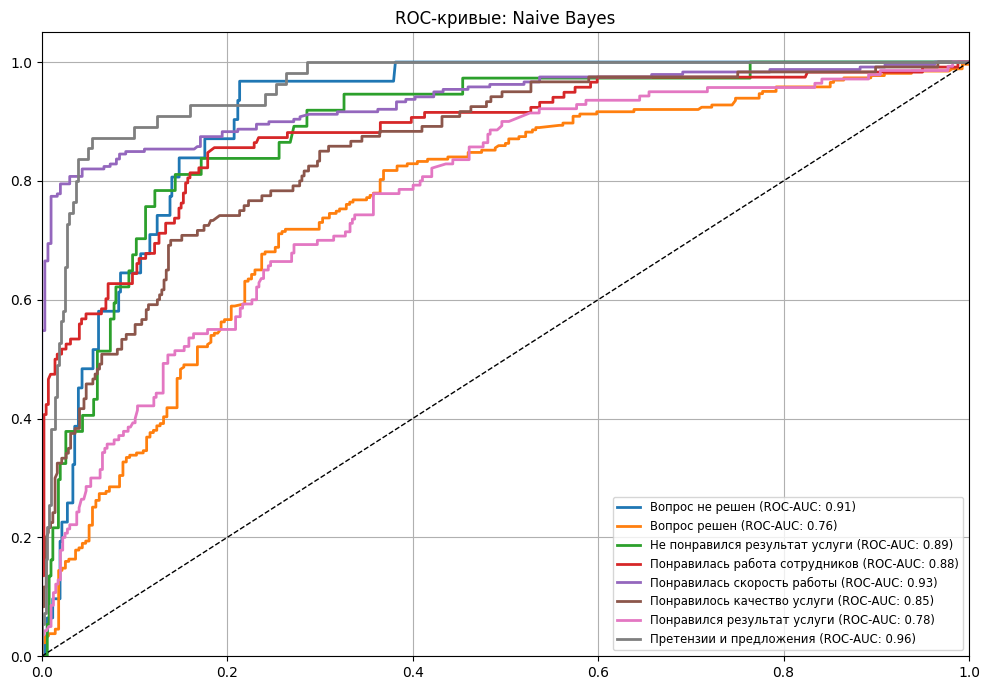

In [102]:
# Визуализация ROC-кривых
plt.figure(figsize=(10, 7))
for i, col in enumerate(y.columns):
    try:
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = sk_auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{col} (ROC-AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Ошибка ROC-кривой для {col}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC-кривые: Naive Bayes')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Классификация на основе модели MultinomialNB

In [103]:
# Функция для предсказания на новых текстах (пример)
def predict_labels(text):
    X = vectorizer.transform([text])
    preds = model.predict(X)
    preds = preds[0]
    
    labels = ['Вопрос не решен',
    'Вопрос решен',
    'Не понравился результат услуги',
    'Понравилась работа сотрудников',
    'Понравилась скорость работы',
    'Понравилось качество услуги',
    'Понравился результат услуги',
    'Претензии и предложения']
    
    result = {label: bool(pred) for label, pred in zip(labels, preds)}
    return result

if __name__ == "__main__":
    while True:
        text = input("Введите сообщение для классификации (или 'exit' для выхода):\n")
        if text.lower() == 'exit':
            break
        prediction = predict_labels(text)
        print("Категории, выставленные моделью:")
        for cat, val in prediction.items():
            if val:
                print(f" - {cat}")